# **Classification task to fine-tune personal documents**

## **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


##**Importing all libraries we need**




In [ ]:
%%capture

!pip install codecarbon
!pip install mxnet
!pip install vit-keras
!pip install tensorflow-addons==0.16.1

In [ ]:
import os
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from codecarbon import EmissionsTracker
import itertools

from tensorflow.keras.utils import load_img
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence as Sequence
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preproc_mbt3
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
import mxnet as mx
from keras.models import load_model
from enum import Enum
from tensorflow.keras.models import Model

from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
import matplotlib.cm as c_map


##**Constants values**

In [ ]:
## File images path
base_path = "MY_PATH"
base_path_img = "MY_PATH"

## Data Generator values
batch_size = 16
inp_dim = (224,224)
n_channels = 3
n_classes = 10

## Image files list
imgs_list = os.listdir(base_path_img)

## Image size
input_size = (224, 224, 3)

## Training, Validation and Testing Percent
train_perc = 0.7
valid_perc = 0.1

## Epoch numbers for fine tuning
num_epochs = 30

## plotlib results number
num_results = 20


##**Switch case classes**

In [ ]:
## Define different classes to create each label

img_ids = ["ic_CIE.front.", "ic_CIE.rear.", "dl_I11.front.", "dl_I11.rear.", "dl_I10.front.", "dl_I10.rear.", "ic_TES.front.", "ic_TES.rear.", "doc_NR.front.", "doc_NR.rear."]

def switch(img_id):
    for i, id in enumerate(img_ids):
        if id in img_id:
            return i
    return None

## **Data Augmentation**

In [ ]:
#Augment data randomly throw rotation, brightless and lighting

def switch_aug(img_):
  temp_img = img_.copy()
  rndm_value = random.uniform(0.2, 0.6)
  rndm_type = random.randint(0, 2)
  if rndm_type == 0:
    alpha = np.random.normal(0, 100, size=(3,))
    rgb = np.dot(np.asarray([1,1,1]) * alpha, np.ones((3,3)))
    img_ = temp_img + rgb
  elif rndm_type == 1:
    aug = mx.image.BrightnessJitterAug(brightness=rndm_value)
    img_ = aug(temp_img)
  elif rndm_type == 2:
    img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

def augment_data(img_):
  img_ = switch_aug(img_)
  img_ = random_rotation(img_, rg=30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
  return img_

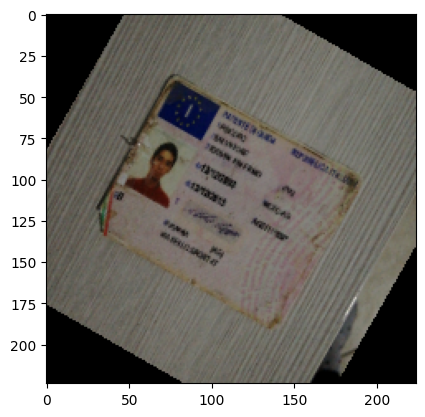

In [ ]:
#Sample

image_path = os.path.join(base_path_img,"dl_I10.front.6397.jpg")
img = load_img(image_path, target_size = inp_dim)
img = img_to_array(img)

img = preproc_mbt3(img)
img = augment_data(img)
img /= 255.0
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.show()

## **Data Generator**

In [ ]:
## Generates data for Keras

class DataGenerator(Sequence):
    def __init__(
        self, all_imgs_list, split_A, split_B,batch_size=batch_size, n_channels=n_channels,
        n_classes=n_classes, inp_dim=inp_dim, train=False, shuffle=False):

        ## Initialization of attributes
        self.list_IDs = all_imgs_list
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inp_dim = inp_dim
        self.shuffle = shuffle
        self.train = train

        ## Get number of all the images contained in the directory

        self.len = len(self.list_IDs)

        ## Split into training, validation or test set
        self.list_IDs = self.list_IDs[int(self.len*split_A):int(self.len*split_B)]
        self.on_epoch_end()

    ## Denotes the number of batches per epoch

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    ## get_item generates one batch of data

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        ## Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        ## Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    ## Updates indexes after each epoch

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle or self.train:
            np.random.shuffle(self.indexes)


    ## Generates data containing batch_size samples

    def __data_generation(self, list_IDs_temp):
        ## Initialization with empty tensors
        X = np.empty((self.batch_size, *self.inp_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data: for i in batch_size fill the input and label vectors
        for i, (ID, augmented) in enumerate(list_IDs_temp):
          ## Get image
          img = load_img(ID, target_size = self.inp_dim)
          img = img_to_array(img)
          img = preproc_mbt3(img)

          current_index_class = switch(ID)
          if self.train:
            if augmented:
                img = augment_data(img)

          ## Store images
          X[i, ] = img

          ## Store classes
          y[i] = current_index_class

        # Converts our classes in one hot encoded vector.
        y = tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, y

In [ ]:
## shuffle datas
random.shuffle(imgs_list)
imgs_list = [os.path.join(base_path_img, img) for img in imgs_list]

## create empty tuple list
imgs_list_aug = []

## create dict with img_class index and all images of that class
balanced_img = {switch(i): [] for i in img_ids}
for j in imgs_list:
  h = switch(j)
  balanced_img[h].append((j, False))

#find the largest class
max_len = max([len(i) for i in balanced_img.values()])

## recreate balanced_img with same dimension
for img_class, img_list_data in balanced_img.items():
  for h in range((max_len + 1) - len(img_list_data)):
    my_list = random.sample(img_list_data,1)
    balanced_img[img_class].append((my_list[0][0], True))

## reduce balanced_img to list
for i in balanced_img.values():
  for j in i:
    imgs_list_aug.append(j)

random.shuffle(imgs_list_aug)

In [ ]:
#Sample to check shuffle is ok

train_gen_number = int((len(imgs_list_aug) * train_perc))
train_data = imgs_list_aug[:train_gen_number]

valid_gen_number = int(len(imgs_list_aug) * (train_perc + valid_perc))
valid_data = imgs_list_aug[len(train_data):valid_gen_number]

test_gen_number = int(len(imgs_list_aug))
test_data = imgs_list_aug[len(train_data + valid_data):test_gen_number]

tot = [(train_data, "train_data"), (valid_data, "valid_data"), (test_data, "test_data")]
for i,name in enumerate(tot):
  ic_CIE_front = []
  ic_CIE_rear = []
  dl_I11_front = []
  dl_I11_rear = []
  dl_I10_front = []
  dl_I10_rear = []
  ic_TES_front = []
  ic_TES_rear = []
  doc_NR_front = []
  doc_NR_rear = []
  for elem in name[0]:
    path = str(elem[0])
    if img_ids[0] in path : ic_CIE_front.append(path)
    elif img_ids[1] in path : ic_CIE_rear.append(path)
    elif img_ids[2] in path : dl_I11_front.append(path)
    elif img_ids[3] in path : dl_I11_rear.append(path)
    elif img_ids[4] in path : dl_I10_front.append(path)
    elif img_ids[5] in path : dl_I10_rear.append(path)
    elif img_ids[6] in path : ic_TES_front.append(path)
    elif img_ids[7] in path : ic_TES_rear.append(path)
    elif img_ids[8] in path : doc_NR_front.append(path)
    elif img_ids[9] in path : doc_NR_rear.append(path)

  print("\n La classe ic_CIE_front ha elementi in " + str(name[1]) + ": " + str(len(ic_CIE_front)),"\n",
      "La classe ic_CIE_rear ha elementi in " + str(name[1]) + ": " + str(len(ic_CIE_rear)),"\n",
      "La classe dl_I11_front ha elementi in " + str(name[1]) + ": " + str(len(dl_I11_front)),"\n",
      "La classe dl_I11_rear ha elementi in " + str(name[1]) + ": " + str(len(dl_I11_rear)),"\n",
      "La classe dl_I10_front ha elementi in " + str(name[1]) + ": " + str(len(dl_I10_front)),"\n",
      "La classe dl_I10_rear ha elementi in " + str(name[1]) + ": " + str(len(dl_I10_rear)),"\n",
      "La classe ic_TES_front ha elementi in " + str(name[1]) + ": " + str(len(ic_TES_front)),"\n",
      "La classe ic_TES_rear ha elementi in " + str(name[1]) + ": " + str(len(ic_TES_rear)),"\n",
      "La classe doc_NR_front ha elementi in " + str(name[1]) + ": " + str(len(doc_NR_front)),"\n",
      "La classe doc_NR_rear ha elementi in " + str(name[1]) + ": " + str(len(doc_NR_rear)),"\n")


 La classe ic_CIE_front ha elementi in train_data: 62 
 La classe ic_CIE_rear ha elementi in train_data: 68 
 La classe dl_I11_front ha elementi in train_data: 65 
 La classe dl_I11_rear ha elementi in train_data: 67 
 La classe dl_I10_front ha elementi in train_data: 66 
 La classe dl_I10_rear ha elementi in train_data: 69 
 La classe ic_TES_front ha elementi in train_data: 66 
 La classe ic_TES_rear ha elementi in train_data: 71 
 La classe doc_NR_front ha elementi in train_data: 66 
 La classe doc_NR_rear ha elementi in train_data: 72 


 La classe ic_CIE_front ha elementi in valid_data: 15 
 La classe ic_CIE_rear ha elementi in valid_data: 11 
 La classe dl_I11_front ha elementi in valid_data: 7 
 La classe dl_I11_rear ha elementi in valid_data: 9 
 La classe dl_I10_front ha elementi in valid_data: 5 
 La classe dl_I10_rear ha elementi in valid_data: 9 
 La classe ic_TES_front ha elementi in valid_data: 14 
 La classe ic_TES_rear ha elementi in valid_data: 9 
 La classe doc_NR_fro

In [ ]:
## Create generator for each model
train_generator = DataGenerator(imgs_list_aug, 0, train_perc, train=True, shuffle=True)
valid_generator = DataGenerator(imgs_list_aug, train_perc, train_perc + valid_perc)
test_generator  = DataGenerator(imgs_list_aug, train_perc + valid_perc, 1)

In [ ]:
#Print generator values

print("Numero di immagini nel generator di addestramento:", len(train_generator) * train_generator.batch_size)
print("Numero di immagini nel generator di validazione:", len(valid_generator) * valid_generator.batch_size)
print("Numero di immagini nel generator di test:", len(test_generator) * test_generator.batch_size)

Numero di immagini nel generator di addestramento: 672
Numero di immagini nel generator di validazione: 80
Numero di immagini nel generator di test: 192


## **Creating model's grid search**

In [ ]:
# Selected and import some models

mbt3 = MobileNetV3Large(input_shape=(input_size[0], input_size[1], input_size[2]), include_top=True, weights='imagenet')

22661472/22661472 [==============================] - 0s 0us/step


In [ ]:
mbt3.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [ ]:
# Function to freeze model, except last four layers

def gen_models(modelInput):
  for layer in modelInput.layers:
      layer.trainable = False
  new_model = modelInput.layers[-2].output
  fc1 = tf.keras.layers.Dense(4096, activation='relu', name = "fc1")(new_model)
  fc2 = tf.keras.layers.Dense(2048, activation='relu', name = "fc2")(fc1)
  fc3 = tf.keras.layers.Dense(1024, activation='relu', name = "fc3")(fc2)
  fc4 = tf.keras.layers.Dense(512, activation='relu', name = "fc4")(fc3)
  softmax = tf.keras.layers.Dense(n_classes, activation='softmax', name = "softmax")(fc4)
  model = tf.keras.models.Model(inputs=modelInput.input, outputs=softmax)
  return model

In [ ]:
# Create our grid search with different fine tuned models

model = gen_models(mbt3)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

## **Find best hyperparameters**

In [ ]:
# Define parameters and create grid search

momentum = 0.9
learning_rates = 0.0001

my_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rates, ema_momentum=momentum)

# **Classification**

In [ ]:
## Create a directory where the model weights will be saved
path_ = base_path

if not os.path.exists (os.path.join(path_, "mbt3_results_")):
  os.mkdir(os.path.join(path_, "mbt3_results_"))
res_dir = os.path.join(path_, "mbt3_results_")

In [ ]:
## Start training our custom model

model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
              optimizer=my_optimizer)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpoint = ModelCheckpoint(os.path.join(res_dir, "model.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
tracker = EmissionsTracker()
tracker.start()
history = model.fit(train_generator, validation_data=valid_generator,
                  epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[checkpoint, es])
emissions: float = tracker.stop()


[codecarbon INFO @ 14:56:07] [setup] RAM Tracking...
[codecarbon INFO @ 14:56:07] [setup] GPU Tracking...
[codecarbon INFO @ 14:56:07] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:56:07] [setup] CPU Tracking...
[codecarbon WARNING @ 14:56:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 14:56:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 14:56:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 14:56:11] >>> Tracker's metadata:
[codecarbon INFO @ 14:56:11]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.31
[codecarbon INFO @ 14:56:11]   Python version: 3.10.12
[codecarbon INFO @ 14:56:11]   CodeCarbon version: 2.2.5
[codecarbon INFO @ 14:56:11]   Available RAM : 12.678 GB
[codecarbon INFO @ 14:56:11]   CPU count: 2
[codecarbon INFO @ 14:56:11]   CPU model: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 14:56:11]   GPU

Epoch 1/30


[codecarbon INFO @ 14:56:26] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:56:26] Energy consumed for all GPUs : 0.000110 kWh. Total GPU Power : 26.361000000000004 W
[codecarbon INFO @ 14:56:26] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:26] 0.000307 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:41] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:56:41] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 26.545 W
[codecarbon INFO @ 14:56:41] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:41] 0.000615 kWh of electricity used since the beginning.


15/42 [=========>....................] - ETA: 26s - loss: 1.6984 - accuracy: 0.5125

[codecarbon INFO @ 14:56:56] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:56:56] Energy consumed for all GPUs : 0.000331 kWh. Total GPU Power : 26.658 W
[codecarbon INFO @ 14:56:56] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:56] 0.000922 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 13s - loss: 1.2380 - accuracy: 0.6422

[codecarbon INFO @ 14:57:11] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:57:11] Energy consumed for all GPUs : 0.000443 kWh. Total GPU Power : 26.841 W
[codecarbon INFO @ 14:57:11] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:11] 0.001231 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.9935 - accuracy: 0.7098

[codecarbon INFO @ 14:57:26] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:57:26] Energy consumed for all GPUs : 0.000555 kWh. Total GPU Power : 26.94 W
[codecarbon INFO @ 14:57:26] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:26] 0.001540 kWh of electricity used since the beginning.



Epoch 1: val_loss improved from inf to 0.25715, saving model to /content/gdrive/MyDrive/TestCV&DL/mbt3_results_/model.h5
42/42 [==============================] - 73s 1s/step - loss: 0.9935 - accuracy: 0.7098 - val_loss: 0.2571 - val_accuracy: 0.8875
Epoch 2/30
 4/42 [=>............................] - ETA: 50s - loss: 0.3782 - accuracy: 0.8906

[codecarbon INFO @ 14:57:41] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:57:41] Energy consumed for all GPUs : 0.000668 kWh. Total GPU Power : 26.94 W
[codecarbon INFO @ 14:57:41] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:41] 0.001849 kWh of electricity used since the beginning.


16/42 [==========>...................] - ETA: 31s - loss: 0.3863 - accuracy: 0.8789

[codecarbon INFO @ 14:57:56] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:57:56] Energy consumed for all GPUs : 0.000780 kWh. Total GPU Power : 26.955000000000002 W
[codecarbon INFO @ 14:57:56] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:56] 0.002159 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 31s - loss: 0.3500 - accuracy: 0.8892

[codecarbon INFO @ 14:58:11] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:58:11] Energy consumed for all GPUs : 0.000892 kWh. Total GPU Power : 27.039 W
[codecarbon INFO @ 14:58:11] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:11] 0.002468 kWh of electricity used since the beginning.


34/42 [=======================>......] - ETA: 11s - loss: 0.3238 - accuracy: 0.8971

[codecarbon INFO @ 14:58:26] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:58:26] Energy consumed for all GPUs : 0.001064 kWh. Total GPU Power : 41.157000000000004 W
[codecarbon INFO @ 14:58:26] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:26] 0.002836 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9003
Epoch 2: val_loss improved from 0.25715 to 0.16920, saving model to /content/gdrive/MyDrive/TestCV&DL/mbt3_results_/model.h5
42/42 [==============================] - 65s 2s/step - loss: 0.3126 - accuracy: 0.9003 - val_loss: 0.1692 - val_accuracy: 0.9250
Epoch 3/30


[codecarbon INFO @ 14:58:41] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:58:41] Energy consumed for all GPUs : 0.001177 kWh. Total GPU Power : 27.237000000000002 W
[codecarbon INFO @ 14:58:41] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:41] 0.003146 kWh of electricity used since the beginning.


15/42 [=========>....................] - ETA: 28s - loss: 0.1297 - accuracy: 0.9750

[codecarbon INFO @ 14:58:56] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:58:56] Energy consumed for all GPUs : 0.001290 kWh. Total GPU Power : 27.237000000000002 W
[codecarbon INFO @ 14:58:56] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:56] 0.003457 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 13s - loss: 0.1209 - accuracy: 0.9677

[codecarbon INFO @ 14:59:11] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:59:11] Energy consumed for all GPUs : 0.001404 kWh. Total GPU Power : 27.336000000000002 W
[codecarbon INFO @ 14:59:11] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:11] 0.003767 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9747

[codecarbon INFO @ 14:59:26] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:59:26] Energy consumed for all GPUs : 0.001518 kWh. Total GPU Power : 27.336000000000002 W
[codecarbon INFO @ 14:59:26] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:26] 0.004078 kWh of electricity used since the beginning.



Epoch 3: val_loss improved from 0.16920 to 0.05072, saving model to /content/gdrive/MyDrive/TestCV&DL/mbt3_results_/model.h5
42/42 [==============================] - 50s 1s/step - loss: 0.1097 - accuracy: 0.9747 - val_loss: 0.0507 - val_accuracy: 1.0000
Epoch 4/30
 8/42 [====>.........................] - ETA: 39s - loss: 0.1161 - accuracy: 0.9766

[codecarbon INFO @ 14:59:41] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:59:41] Energy consumed for all GPUs : 0.001632 kWh. Total GPU Power : 27.435000000000006 W
[codecarbon INFO @ 14:59:41] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:41] 0.004389 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 22s - loss: 0.1380 - accuracy: 0.9631

[codecarbon INFO @ 14:59:56] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 14:59:56] Energy consumed for all GPUs : 0.001747 kWh. Total GPU Power : 27.533 W
[codecarbon INFO @ 14:59:56] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:56] 0.004700 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 5s - loss: 0.1455 - accuracy: 0.9595

[codecarbon INFO @ 15:00:11] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:00:11] Energy consumed for all GPUs : 0.001862 kWh. Total GPU Power : 27.632 W
[codecarbon INFO @ 15:00:11] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:11] 0.005012 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9568
Epoch 4: val_loss did not improve from 0.05072
42/42 [==============================] - 49s 1s/step - loss: 0.1469 - accuracy: 0.9568 - val_loss: 0.1093 - val_accuracy: 0.9875
Epoch 5/30
 5/42 [==>...........................] - ETA: 34s - loss: 0.1932 - accuracy: 0.9500

[codecarbon INFO @ 15:00:26] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:00:26] Energy consumed for all GPUs : 0.001976 kWh. Total GPU Power : 27.533 W
[codecarbon INFO @ 15:00:26] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:26] 0.005323 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9375

[codecarbon INFO @ 15:00:41] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:00:41] Energy consumed for all GPUs : 0.002091 kWh. Total GPU Power : 27.533 W
[codecarbon INFO @ 15:00:41] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:41] 0.005635 kWh of electricity used since the beginning.


34/42 [=======================>......] - ETA: 8s - loss: 0.1752 - accuracy: 0.9522

[codecarbon INFO @ 15:00:56] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:00:56] Energy consumed for all GPUs : 0.002206 kWh. Total GPU Power : 27.632 W
[codecarbon INFO @ 15:00:56] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:56] 0.005946 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9539
Epoch 5: val_loss improved from 0.05072 to 0.05040, saving model to /content/gdrive/MyDrive/TestCV&DL/mbt3_results_/model.h5


[codecarbon INFO @ 15:01:11] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:01:11] Energy consumed for all GPUs : 0.002320 kWh. Total GPU Power : 27.533 W
[codecarbon INFO @ 15:01:11] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:11] 0.006258 kWh of electricity used since the beginning.


42/42 [==============================] - 52s 1s/step - loss: 0.1740 - accuracy: 0.9539 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 6/30
12/42 [=======>......................] - ETA: 34s - loss: 0.1334 - accuracy: 0.9531

[codecarbon INFO @ 15:01:26] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:01:26] Energy consumed for all GPUs : 0.002436 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:01:26] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:26] 0.006570 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 16s - loss: 0.1221 - accuracy: 0.9653

[codecarbon INFO @ 15:01:41] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:01:41] Energy consumed for all GPUs : 0.002551 kWh. Total GPU Power : 27.632 W
[codecarbon INFO @ 15:01:41] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:41] 0.006882 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9658

[codecarbon INFO @ 15:01:56] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:01:56] Energy consumed for all GPUs : 0.002666 kWh. Total GPU Power : 27.632 W
[codecarbon INFO @ 15:01:56] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:56] 0.007194 kWh of electricity used since the beginning.



Epoch 6: val_loss did not improve from 0.05040
42/42 [==============================] - 48s 1s/step - loss: 0.1244 - accuracy: 0.9658 - val_loss: 0.0909 - val_accuracy: 0.9625
Epoch 7/30
10/42 [======>.......................] - ETA: 33s - loss: 0.1123 - accuracy: 0.9688

[codecarbon INFO @ 15:02:11] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:02:11] Energy consumed for all GPUs : 0.002781 kWh. Total GPU Power : 27.632 W
[codecarbon INFO @ 15:02:11] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:11] 0.007506 kWh of electricity used since the beginning.


24/42 [================>.............] - ETA: 19s - loss: 0.1220 - accuracy: 0.9609

[codecarbon INFO @ 15:02:26] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:02:26] Energy consumed for all GPUs : 0.002896 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:02:26] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:26] 0.007818 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 3s - loss: 0.1695 - accuracy: 0.9503

[codecarbon INFO @ 15:02:41] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:02:41] Energy consumed for all GPUs : 0.003012 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:02:41] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:41] 0.008131 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9524
Epoch 7: val_loss did not improve from 0.05040
42/42 [==============================] - 49s 1s/step - loss: 0.1604 - accuracy: 0.9524 - val_loss: 0.0949 - val_accuracy: 0.9750


[codecarbon INFO @ 15:02:56] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:02:56] Energy consumed for all GPUs : 0.003128 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:02:56] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:56] 0.008443 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:03:11] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:03:11] Energy consumed for all GPUs : 0.003243 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:03:11] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:11] 0.008756 kWh of electricity used since the beginning.


Epoch 8/30
 4/42 [=>............................] - ETA: 37s - loss: 0.1512 - accuracy: 0.9688

[codecarbon INFO @ 15:03:26] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:03:26] Energy consumed for all GPUs : 0.003358 kWh. Total GPU Power : 27.632 W
[codecarbon INFO @ 15:03:26] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:26] 0.009068 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9549

[codecarbon INFO @ 15:03:41] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:03:41] Energy consumed for all GPUs : 0.003474 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:03:41] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:41] 0.009380 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 9s - loss: 0.1537 - accuracy: 0.9508 

[codecarbon INFO @ 15:03:56] Energy consumed for RAM : 0.000613 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:03:56] Energy consumed for all GPUs : 0.003590 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:03:56] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:56] 0.009693 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9524
Epoch 8: val_loss did not improve from 0.05040
42/42 [==============================] - 47s 1s/step - loss: 0.1453 - accuracy: 0.9524 - val_loss: 0.1091 - val_accuracy: 0.9625
Epoch 9/30
 1/42 [..............................] - ETA: 56s - loss: 0.0237 - accuracy: 1.0000

[codecarbon INFO @ 15:04:11] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:04:11] Energy consumed for all GPUs : 0.003706 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:04:11] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:11] 0.010006 kWh of electricity used since the beginning.


15/42 [=========>....................] - ETA: 27s - loss: 0.1256 - accuracy: 0.9583

[codecarbon INFO @ 15:04:26] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:04:26] Energy consumed for all GPUs : 0.003821 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:04:26] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:26] 0.010318 kWh of electricity used since the beginning.


30/42 [====================>.........] - ETA: 12s - loss: 0.1135 - accuracy: 0.9604

[codecarbon INFO @ 15:04:41] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:04:41] Energy consumed for all GPUs : 0.003937 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:04:41] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:41] 0.010631 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9628

[codecarbon INFO @ 15:04:56] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:04:56] Energy consumed for all GPUs : 0.004053 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:04:56] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:56] 0.010944 kWh of electricity used since the beginning.



Epoch 9: val_loss did not improve from 0.05040
42/42 [==============================] - 53s 1s/step - loss: 0.1572 - accuracy: 0.9628 - val_loss: 0.0909 - val_accuracy: 0.9750
Epoch 10/30
 8/42 [====>.........................] - ETA: 36s - loss: 0.0802 - accuracy: 0.9766

[codecarbon INFO @ 15:05:11] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:05:11] Energy consumed for all GPUs : 0.004169 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:05:11] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:11] 0.011256 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 21s - loss: 0.1260 - accuracy: 0.9602

[codecarbon INFO @ 15:05:26] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:05:26] Energy consumed for all GPUs : 0.004284 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:05:26] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:26] 0.011569 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 5s - loss: 0.1034 - accuracy: 0.9662

[codecarbon INFO @ 15:05:41] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:05:41] Energy consumed for all GPUs : 0.004400 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:05:41] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:41] 0.011881 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9673
Epoch 10: val_loss did not improve from 0.05040
42/42 [==============================] - 47s 1s/step - loss: 0.1052 - accuracy: 0.9673 - val_loss: 0.0571 - val_accuracy: 0.9875
Epoch 11/30
 6/42 [===>..........................] - ETA: 42s - loss: 0.0312 - accuracy: 1.0000

[codecarbon INFO @ 15:05:56] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:05:56] Energy consumed for all GPUs : 0.004517 kWh. Total GPU Power : 28.028000000000006 W
[codecarbon INFO @ 15:05:56] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:56] 0.012194 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 21s - loss: 0.0961 - accuracy: 0.9762

[codecarbon INFO @ 15:06:11] Energy consumed for RAM : 0.000791 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:06:11] Energy consumed for all GPUs : 0.004633 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:06:11] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:11] 0.012507 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 7s - loss: 0.1107 - accuracy: 0.9696

[codecarbon INFO @ 15:06:26] Energy consumed for RAM : 0.000811 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:06:26] Energy consumed for all GPUs : 0.004748 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:06:26] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:26] 0.012820 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9702
Epoch 11: val_loss did not improve from 0.05040
42/42 [==============================] - 47s 1s/step - loss: 0.1055 - accuracy: 0.9702 - val_loss: 0.1121 - val_accuracy: 0.9375


[codecarbon INFO @ 15:06:41] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:06:41] Energy consumed for all GPUs : 0.004864 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:06:41] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:41] 0.013132 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:56] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:06:56] Energy consumed for all GPUs : 0.004980 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:06:56] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:56] 0.013445 kWh of electricity used since the beginning.


Epoch 12/30


[codecarbon INFO @ 15:07:11] Energy consumed for RAM : 0.000870 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:07:11] Energy consumed for all GPUs : 0.005096 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:07:11] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:11] 0.013757 kWh of electricity used since the beginning.


14/42 [=========>....................] - ETA: 28s - loss: 0.0749 - accuracy: 0.9688

[codecarbon INFO @ 15:07:26] Energy consumed for RAM : 0.000890 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:07:26] Energy consumed for all GPUs : 0.005212 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:07:26] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:26] 0.014070 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 13s - loss: 0.0611 - accuracy: 0.9763

[codecarbon INFO @ 15:07:41] Energy consumed for RAM : 0.000910 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:07:41] Energy consumed for all GPUs : 0.005328 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:07:41] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:41] 0.014383 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9792

[codecarbon INFO @ 15:07:56] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:07:56] Energy consumed for all GPUs : 0.005444 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:07:56] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:07:56] 0.014696 kWh of electricity used since the beginning.



Epoch 12: val_loss improved from 0.05040 to 0.02339, saving model to /content/gdrive/MyDrive/TestCV&DL/mbt3_results_/model.h5
42/42 [==============================] - 52s 1s/step - loss: 0.0626 - accuracy: 0.9792 - val_loss: 0.0234 - val_accuracy: 0.9875
Epoch 13/30
 8/42 [====>.........................] - ETA: 30s - loss: 0.0773 - accuracy: 0.9766

[codecarbon INFO @ 15:08:11] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:08:11] Energy consumed for all GPUs : 0.005560 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:08:11] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:11] 0.015009 kWh of electricity used since the beginning.


22/42 [==============>...............] - ETA: 20s - loss: 0.1058 - accuracy: 0.9716

[codecarbon INFO @ 15:08:26] Energy consumed for RAM : 0.000969 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:08:26] Energy consumed for all GPUs : 0.005676 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:08:26] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:26] 0.015321 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 5s - loss: 0.0789 - accuracy: 0.9780

[codecarbon INFO @ 15:08:41] Energy consumed for RAM : 0.000989 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:08:41] Energy consumed for all GPUs : 0.005797 kWh. Total GPU Power : 29.116 W
[codecarbon INFO @ 15:08:41] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:41] 0.015639 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9762
Epoch 13: val_loss did not improve from 0.02339
42/42 [==============================] - 48s 1s/step - loss: 0.0836 - accuracy: 0.9762 - val_loss: 0.0344 - val_accuracy: 0.9875
Epoch 14/30
 5/42 [==>...........................] - ETA: 35s - loss: 0.0454 - accuracy: 0.9875

[codecarbon INFO @ 15:08:56] Energy consumed for RAM : 0.001009 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:08:56] Energy consumed for all GPUs : 0.005913 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:08:57] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:08:57] 0.015952 kWh of electricity used since the beginning.


19/42 [============>.................] - ETA: 23s - loss: 0.0704 - accuracy: 0.9803

[codecarbon INFO @ 15:09:11] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:09:11] Energy consumed for all GPUs : 0.006029 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:09:12] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:12] 0.016266 kWh of electricity used since the beginning.


34/42 [=======================>......] - ETA: 8s - loss: 0.0722 - accuracy: 0.9779

[codecarbon INFO @ 15:09:26] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:09:26] Energy consumed for all GPUs : 0.006145 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:09:27] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:27] 0.016578 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9777
Epoch 14: val_loss did not improve from 0.02339
42/42 [==============================] - 47s 1s/step - loss: 0.0758 - accuracy: 0.9777 - val_loss: 0.0289 - val_accuracy: 0.9875
Epoch 15/30
 2/42 [>.............................] - ETA: 35s - loss: 0.0308 - accuracy: 1.0000

[codecarbon INFO @ 15:09:41] Energy consumed for RAM : 0.001068 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:09:42] Energy consumed for all GPUs : 0.006261 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:09:42] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:42] 0.016891 kWh of electricity used since the beginning.


16/42 [==========>...................] - ETA: 27s - loss: 0.1163 - accuracy: 0.9609

[codecarbon INFO @ 15:09:57] Energy consumed for RAM : 0.001088 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:09:57] Energy consumed for all GPUs : 0.006376 kWh. Total GPU Power : 27.815 W
[codecarbon INFO @ 15:09:57] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:09:57] 0.017203 kWh of electricity used since the beginning.


31/42 [=====================>........] - ETA: 11s - loss: 0.0882 - accuracy: 0.9738

[codecarbon INFO @ 15:10:12] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:10:12] Energy consumed for all GPUs : 0.006492 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:10:12] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:12] 0.017516 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9673
Epoch 15: val_loss did not improve from 0.02339
42/42 [==============================] - 47s 1s/step - loss: 0.1149 - accuracy: 0.9673 - val_loss: 0.1153 - val_accuracy: 0.9500
Epoch 16/30


[codecarbon INFO @ 15:10:27] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:10:27] Energy consumed for all GPUs : 0.006607 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:10:27] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:27] 0.017828 kWh of electricity used since the beginning.


15/42 [=========>....................] - ETA: 26s - loss: 0.1100 - accuracy: 0.9583

[codecarbon INFO @ 15:10:42] Energy consumed for RAM : 0.001147 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:10:42] Energy consumed for all GPUs : 0.006724 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:10:42] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:42] 0.018141 kWh of electricity used since the beginning.


29/42 [===================>..........] - ETA: 12s - loss: 0.0896 - accuracy: 0.9763

[codecarbon INFO @ 15:10:57] Energy consumed for RAM : 0.001167 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:10:57] Energy consumed for all GPUs : 0.006840 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:10:57] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:57] 0.018454 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9732

[codecarbon INFO @ 15:11:12] Energy consumed for RAM : 0.001187 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:11:12] Energy consumed for all GPUs : 0.006956 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:11:12] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:12] 0.018766 kWh of electricity used since the beginning.



Epoch 16: val_loss did not improve from 0.02339
42/42 [==============================] - 48s 1s/step - loss: 0.0920 - accuracy: 0.9732 - val_loss: 0.0394 - val_accuracy: 1.0000
Epoch 17/30
11/42 [======>.......................] - ETA: 29s - loss: 0.0477 - accuracy: 0.9943

[codecarbon INFO @ 15:11:27] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:11:27] Energy consumed for all GPUs : 0.007072 kWh. Total GPU Power : 27.929000000000002 W


12/42 [=======>......................] - ETA: 29s - loss: 0.0445 - accuracy: 0.9948

[codecarbon INFO @ 15:11:27] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:27] 0.019080 kWh of electricity used since the beginning.


26/42 [=================>............] - ETA: 16s - loss: 0.0688 - accuracy: 0.9808

[codecarbon INFO @ 15:11:42] Energy consumed for RAM : 0.001226 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:11:42] Energy consumed for all GPUs : 0.007187 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:11:42] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:42] 0.019392 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 1s - loss: 0.0555 - accuracy: 0.9848

[codecarbon INFO @ 15:11:57] Energy consumed for RAM : 0.001246 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:11:57] Energy consumed for all GPUs : 0.007303 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:11:57] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:57] 0.019704 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9836
Epoch 17: val_loss improved from 0.02339 to 0.01169, saving model to /content/gdrive/MyDrive/TestCV&DL/mbt3_results_/model.h5
42/42 [==============================] - 50s 1s/step - loss: 0.0589 - accuracy: 0.9836 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 18/30
 6/42 [===>..........................] - ETA: 40s - loss: 0.0317 - accuracy: 0.9792

[codecarbon INFO @ 15:12:12] Energy consumed for RAM : 0.001266 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:12:12] Energy consumed for all GPUs : 0.007419 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:12:12] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:12] 0.020017 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 23s - loss: 0.0930 - accuracy: 0.9719

[codecarbon INFO @ 15:12:27] Energy consumed for RAM : 0.001286 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:12:27] Energy consumed for all GPUs : 0.007534 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:12:27] Energy consumed for all CPUs : 0.011509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:27] 0.020329 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 7s - loss: 0.0829 - accuracy: 0.9786

[codecarbon INFO @ 15:12:42] Energy consumed for RAM : 0.001306 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:12:42] Energy consumed for all GPUs : 0.007650 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:12:42] Energy consumed for all CPUs : 0.011686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:42] 0.020642 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9747
Epoch 18: val_loss did not improve from 0.01169
42/42 [==============================] - 47s 1s/step - loss: 0.0962 - accuracy: 0.9747 - val_loss: 0.0363 - val_accuracy: 0.9875
Epoch 19/30
 3/42 [=>............................] - ETA: 48s - loss: 0.0664 - accuracy: 0.9792

[codecarbon INFO @ 15:12:57] Energy consumed for RAM : 0.001325 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:12:57] Energy consumed for all GPUs : 0.007766 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:12:57] Energy consumed for all CPUs : 0.011863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:57] 0.020954 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 25s - loss: 0.0853 - accuracy: 0.9722

[codecarbon INFO @ 15:13:12] Energy consumed for RAM : 0.001345 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:13:12] Energy consumed for all GPUs : 0.007882 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:13:12] Energy consumed for all CPUs : 0.012040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:12] 0.021267 kWh of electricity used since the beginning.


32/42 [=====================>........] - ETA: 10s - loss: 0.1023 - accuracy: 0.9707

[codecarbon INFO @ 15:13:27] Energy consumed for RAM : 0.001365 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:13:27] Energy consumed for all GPUs : 0.007998 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:13:27] Energy consumed for all CPUs : 0.012217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:27] 0.021580 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9628
Epoch 19: val_loss did not improve from 0.01169
42/42 [==============================] - 48s 1s/step - loss: 0.1116 - accuracy: 0.9628 - val_loss: 0.0232 - val_accuracy: 1.0000


[codecarbon INFO @ 15:13:42] Energy consumed for RAM : 0.001385 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:13:42] Energy consumed for all GPUs : 0.008113 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:13:42] Energy consumed for all CPUs : 0.012394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:42] 0.021892 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:13:57] Energy consumed for RAM : 0.001404 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:13:57] Energy consumed for all GPUs : 0.008229 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:13:57] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:13:57] 0.022205 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:12] Energy consumed for RAM : 0.001424 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:14:12] Energy consumed for all GPUs : 0.008345 kWh. Total GPU Power : 27.830000000000

Epoch 20/30
11/42 [======>.......................] - ETA: 33s - loss: 0.1326 - accuracy: 0.9602

[codecarbon INFO @ 15:14:27] Energy consumed for RAM : 0.001444 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:14:27] Energy consumed for all GPUs : 0.008461 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:14:27] Energy consumed for all CPUs : 0.012925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:27] 0.022830 kWh of electricity used since the beginning.


27/42 [==================>...........] - ETA: 15s - loss: 0.0906 - accuracy: 0.9699

[codecarbon INFO @ 15:14:42] Energy consumed for RAM : 0.001464 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:14:42] Energy consumed for all GPUs : 0.008646 kWh. Total GPU Power : 44.554 W
[codecarbon INFO @ 15:14:42] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:42] 0.023212 kWh of electricity used since the beginning.


41/42 [============================>.] - ETA: 1s - loss: 0.0808 - accuracy: 0.9710

[codecarbon INFO @ 15:14:57] Energy consumed for RAM : 0.001484 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:14:57] Energy consumed for all GPUs : 0.008762 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:14:57] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:57] 0.023526 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9717
Epoch 20: val_loss did not improve from 0.01169
42/42 [==============================] - 47s 1s/step - loss: 0.0791 - accuracy: 0.9717 - val_loss: 0.0761 - val_accuracy: 0.9875
Epoch 21/30
10/42 [======>.......................] - ETA: 34s - loss: 0.1146 - accuracy: 0.9688

[codecarbon INFO @ 15:15:12] Energy consumed for RAM : 0.001503 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:15:12] Energy consumed for all GPUs : 0.008879 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:15:12] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:12] 0.023839 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 17s - loss: 0.1010 - accuracy: 0.9750

[codecarbon INFO @ 15:15:27] Energy consumed for RAM : 0.001523 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:15:27] Energy consumed for all GPUs : 0.009021 kWh. Total GPU Power : 34.218 W
[codecarbon INFO @ 15:15:27] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:27] 0.024178 kWh of electricity used since the beginning.


39/42 [==========================>...] - ETA: 3s - loss: 0.1064 - accuracy: 0.9696

[codecarbon INFO @ 15:15:42] Energy consumed for RAM : 0.001543 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:15:42] Energy consumed for all GPUs : 0.009137 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:15:42] Energy consumed for all CPUs : 0.013811 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:42] 0.024491 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9688
Epoch 21: val_loss did not improve from 0.01169
42/42 [==============================] - 48s 1s/step - loss: 0.1057 - accuracy: 0.9688 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 22/30
 8/42 [====>.........................] - ETA: 30s - loss: 0.1550 - accuracy: 0.9453

[codecarbon INFO @ 15:15:57] Energy consumed for RAM : 0.001563 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:15:57] Energy consumed for all GPUs : 0.009253 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:15:57] Energy consumed for all CPUs : 0.013988 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:57] 0.024804 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 18s - loss: 0.0926 - accuracy: 0.9674

[codecarbon INFO @ 15:16:12] Energy consumed for RAM : 0.001583 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:16:12] Energy consumed for all GPUs : 0.009369 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:16:12] Energy consumed for all CPUs : 0.014165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:12] 0.025117 kWh of electricity used since the beginning.


37/42 [=========================>....] - ETA: 4s - loss: 0.1026 - accuracy: 0.9645

[codecarbon INFO @ 15:16:27] Energy consumed for RAM : 0.001602 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:16:27] Energy consumed for all GPUs : 0.009485 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:16:27] Energy consumed for all CPUs : 0.014342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:27] 0.025429 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9658
Epoch 22: val_loss did not improve from 0.01169
42/42 [==============================] - 47s 1s/step - loss: 0.1002 - accuracy: 0.9658 - val_loss: 0.1411 - val_accuracy: 0.9625
Epoch 23/30
 6/42 [===>..........................] - ETA: 31s - loss: 0.1580 - accuracy: 0.9583

[codecarbon INFO @ 15:16:42] Energy consumed for RAM : 0.001622 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:16:42] Energy consumed for all GPUs : 0.009600 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:16:42] Energy consumed for all CPUs : 0.014519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:42] 0.025742 kWh of electricity used since the beginning.


21/42 [==============>...............] - ETA: 20s - loss: 0.0813 - accuracy: 0.9762

[codecarbon INFO @ 15:16:57] Energy consumed for RAM : 0.001642 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:16:57] Energy consumed for all GPUs : 0.009758 kWh. Total GPU Power : 37.806 W
[codecarbon INFO @ 15:16:57] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:16:57] 0.026096 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 6s - loss: 0.0889 - accuracy: 0.9714

[codecarbon INFO @ 15:17:12] Energy consumed for RAM : 0.001662 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:17:12] Energy consumed for all GPUs : 0.009874 kWh. Total GPU Power : 27.929000000000002 W
[codecarbon INFO @ 15:17:12] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:12] 0.026410 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9747
Epoch 23: val_loss did not improve from 0.01169
42/42 [==============================] - 47s 1s/step - loss: 0.0791 - accuracy: 0.9747 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 24/30
 4/42 [=>............................] - ETA: 31s - loss: 0.0164 - accuracy: 1.0000

[codecarbon INFO @ 15:17:27] Energy consumed for RAM : 0.001681 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:17:27] Energy consumed for all GPUs : 0.009990 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:17:27] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:27] 0.026722 kWh of electricity used since the beginning.


18/42 [===========>..................] - ETA: 23s - loss: 0.0614 - accuracy: 0.9861

[codecarbon INFO @ 15:17:42] Energy consumed for RAM : 0.001701 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:17:42] Energy consumed for all GPUs : 0.010106 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:17:42] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:42] 0.027035 kWh of electricity used since the beginning.


33/42 [======================>.......] - ETA: 9s - loss: 0.0551 - accuracy: 0.9811 

[codecarbon INFO @ 15:17:57] Energy consumed for RAM : 0.001721 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:17:57] Energy consumed for all GPUs : 0.010231 kWh. Total GPU Power : 30.186 W
[codecarbon INFO @ 15:17:57] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:17:57] 0.027357 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9777
Epoch 24: val_loss did not improve from 0.01169
42/42 [==============================] - 47s 1s/step - loss: 0.0635 - accuracy: 0.9777 - val_loss: 0.0587 - val_accuracy: 0.9875


[codecarbon INFO @ 15:18:12] Energy consumed for RAM : 0.001741 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:18:12] Energy consumed for all GPUs : 0.010348 kWh. Total GPU Power : 28.028000000000006 W
[codecarbon INFO @ 15:18:12] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:12] 0.027671 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:27] Energy consumed for RAM : 0.001761 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:18:27] Energy consumed for all GPUs : 0.010464 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:18:27] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:27] 0.027983 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:18:42] Energy consumed for RAM : 0.001780 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:18:42] Energy consumed for all GPUs : 0.010579 kWh. Total GPU Power : 27.731 W
[codec

Epoch 25/30
11/42 [======>.......................] - ETA: 32s - loss: 0.0702 - accuracy: 0.9773

[codecarbon INFO @ 15:18:57] Energy consumed for RAM : 0.001800 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:18:57] Energy consumed for all GPUs : 0.010696 kWh. Total GPU Power : 27.997 W
[codecarbon INFO @ 15:18:57] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:57] 0.028609 kWh of electricity used since the beginning.


25/42 [================>.............] - ETA: 17s - loss: 0.0862 - accuracy: 0.9725

[codecarbon INFO @ 15:19:12] Energy consumed for RAM : 0.001820 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:19:12] Energy consumed for all GPUs : 0.010812 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:19:12] Energy consumed for all CPUs : 0.016290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:12] 0.028922 kWh of electricity used since the beginning.


40/42 [===========================>..] - ETA: 2s - loss: 0.0889 - accuracy: 0.9719

[codecarbon INFO @ 15:19:27] Energy consumed for RAM : 0.001840 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:19:27] Energy consumed for all GPUs : 0.010928 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:19:27] Energy consumed for all CPUs : 0.016467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:27] 0.029235 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9717
Epoch 25: val_loss did not improve from 0.01169
42/42 [==============================] - 47s 1s/step - loss: 0.0874 - accuracy: 0.9717 - val_loss: 0.0887 - val_accuracy: 0.9750
Epoch 26/30
 8/42 [====>.........................] - ETA: 39s - loss: 0.0708 - accuracy: 0.9766

[codecarbon INFO @ 15:19:42] Energy consumed for RAM : 0.001860 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:19:42] Energy consumed for all GPUs : 0.011043 kWh. Total GPU Power : 27.731 W
[codecarbon INFO @ 15:19:42] Energy consumed for all CPUs : 0.016644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:42] 0.029547 kWh of electricity used since the beginning.


23/42 [===============>..............] - ETA: 20s - loss: 0.0769 - accuracy: 0.9728

[codecarbon INFO @ 15:19:57] Energy consumed for RAM : 0.001879 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:19:57] Energy consumed for all GPUs : 0.011159 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:19:57] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:57] 0.029860 kWh of electricity used since the beginning.


38/42 [==========================>...] - ETA: 4s - loss: 0.0974 - accuracy: 0.9671

[codecarbon INFO @ 15:20:12] Energy consumed for RAM : 0.001899 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:20:12] Energy consumed for all GPUs : 0.011275 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:20:12] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:12] 0.030173 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9658
Epoch 26: val_loss did not improve from 0.01169
42/42 [==============================] - 49s 1s/step - loss: 0.1072 - accuracy: 0.9658 - val_loss: 0.0756 - val_accuracy: 0.9875
Epoch 27/30
 5/42 [==>...........................] - ETA: 37s - loss: 0.1439 - accuracy: 0.9250

[codecarbon INFO @ 15:20:27] Energy consumed for RAM : 0.001919 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:20:27] Energy consumed for all GPUs : 0.011391 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:20:27] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:27] 0.030486 kWh of electricity used since the beginning.


20/42 [=============>................] - ETA: 22s - loss: 0.0826 - accuracy: 0.9719

[codecarbon INFO @ 15:20:42] Energy consumed for RAM : 0.001939 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:20:42] Energy consumed for all GPUs : 0.011507 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:20:42] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:42] 0.030799 kWh of electricity used since the beginning.


35/42 [========================>.....] - ETA: 7s - loss: 0.0846 - accuracy: 0.9714

[codecarbon INFO @ 15:20:57] Energy consumed for RAM : 0.001958 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:20:57] Energy consumed for all GPUs : 0.011622 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:20:57] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:57] 0.031111 kWh of electricity used since the beginning.


42/42 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9702
Epoch 27: val_loss did not improve from 0.01169
42/42 [==============================] - 48s 1s/step - loss: 0.0880 - accuracy: 0.9702 - val_loss: 0.0584 - val_accuracy: 0.9875
Epoch 27: early stopping


[codecarbon INFO @ 15:21:08] Energy consumed for RAM : 0.001974 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 15:21:08] Energy consumed for all GPUs : 0.011712 kWh. Total GPU Power : 27.830000000000005 W
[codecarbon INFO @ 15:21:08] Energy consumed for all CPUs : 0.017667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:21:08] 0.031353 kWh of electricity used since the beginning.


In [ ]:
print(f"Emissions: {emissions} kg")

Emissions: 0.011538018818166828 kg


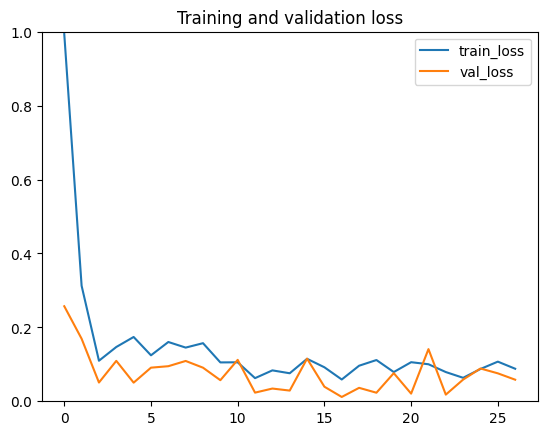

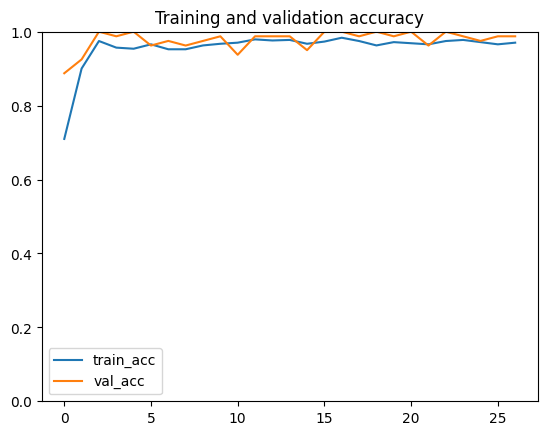

In [ ]:
## Accuracy poltlib
epochs = 27
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.ylim((0,1))
plt.legend()

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.ylim((0,1))
plt.legend()

In [ ]:
# Create history JSON

history_ = pd.DataFrame(history.history)
with open(os.path.join(path_, "mbt3_results_", "history.json"), "w") as json_file:
    history_.to_json(json_file)

In [ ]:
# Load model

model = load_model('MY_PATH_OF_MODEL_H5')

[codecarbon INFO @ 07:34:54] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:34:54] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:34:54] 0.004135 kWh of electricity used since the beginning.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

[codecarbon INFO @ 07:35:09] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.754399299621582 W


[codecarbon INFO @ 07:35:09] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W


 multiply_19 (Multiply)         (None, 7, 7, 960)    0           ['Conv_1/BatchNorm[0][0]',       


[codecarbon INFO @ 07:35:09] 0.004332 kWh of electricity used since the beginning.


                                                                  'tf.math.multiply_27[0][0]']    
                                                                                                  
 global_average_pooling2d (Glob  (None, 1, 1, 960)   0           ['multiply_19[0][0]']            
 alAveragePooling2D)                                                                              
                                                                                                  
 Conv_2 (Conv2D)                (None, 1, 1, 1280)   1230080     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 1, 1, 1280)  0           ['Conv_2[0][0]']                 
 ambda)                                                                                           
          

## **Testing**

In [ ]:
# Inference with testgenerator

y_pred = model.predict(test_generator)
print(y_pred.shape)
y_pred_max = np.argmax(y_pred, 1)

print(y_pred[10])
print(y_pred_max[10])

12/12 [==============================] - 15s 1s/step
(192, 10)
[3.1106531e-06 4.6860555e-06 6.9644494e-07 1.8147176e-07 6.2131534e-07
 6.2367480e-06 1.7825921e-07 9.9998331e-01 5.2011400e-09 9.7086172e-07]
7


In [ ]:
# Crop the test dataset to the lenght of the predictions, which is automatically a multiple of the batch size.

X_test = [x for x,i in test_generator.list_IDs]
Y_test = [switch(str(x)) for x in X_test]

Y_test = Y_test[:len(y_pred_max)]

print(sklearn.metrics.classification_report(Y_test, y_pred_max))

print("accuracy:", accuracy_score(Y_test, y_pred_max))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       1.00      1.00      1.00        17
           2       0.95      0.83      0.89        24
           3       1.00      0.84      0.91        19
           4       0.93      1.00      0.96        25
           5       0.86      1.00      0.92        18
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        17

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192

accuracy: 0.9583333333333334


In [ ]:
## show results

for i in range(num_results):
    fig, ax = plt.subplots()
    ax.imshow(load_img(os.path.join(base_path, X_test[i])))
    ax.set_title(img_ids[y_pred_max[i]])
    plt.show()

##Confusion Matrix

<Axes: >

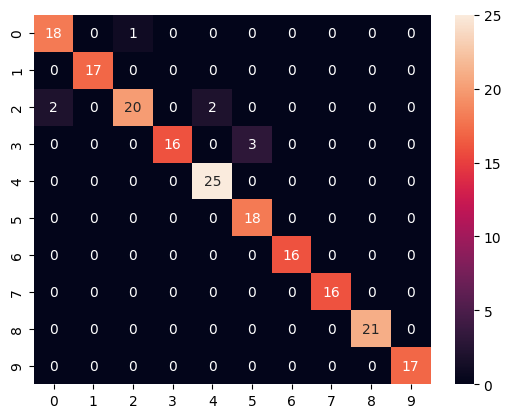

In [ ]:
conf = confusion_matrix(Y_test, y_pred_max)
sns.heatmap(conf, annot=True, fmt="d")

<Axes: >

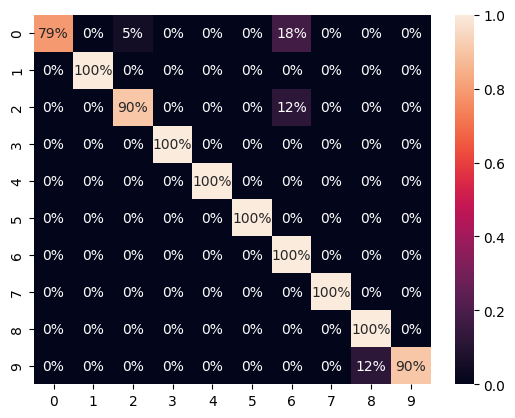

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True, fmt='.0%')

In [ ]:
# Find wrong predictions

array = []
for i in range(0,len(Y_test)):
  if Y_test[i] != y_pred_max[i]:
    array.append(i)

for i in array:
  fig, ax = plt.subplots()
  ax.imshow(load_img(os.path.join(base_path, X_test[i])))
  ax.set_title(X_test[i])
  print(X_test[i])
  print("True Label: " + img_ids[Y_test[i]],"Predicted Label: " + img_ids[y_pred_max[i]],"\n")

Conv_1/BatchNorm
/content/gdrive/MyDrive/Colab Notebooks/progetto/DatasetNew/data/ic_CIE.front.18335.jpg


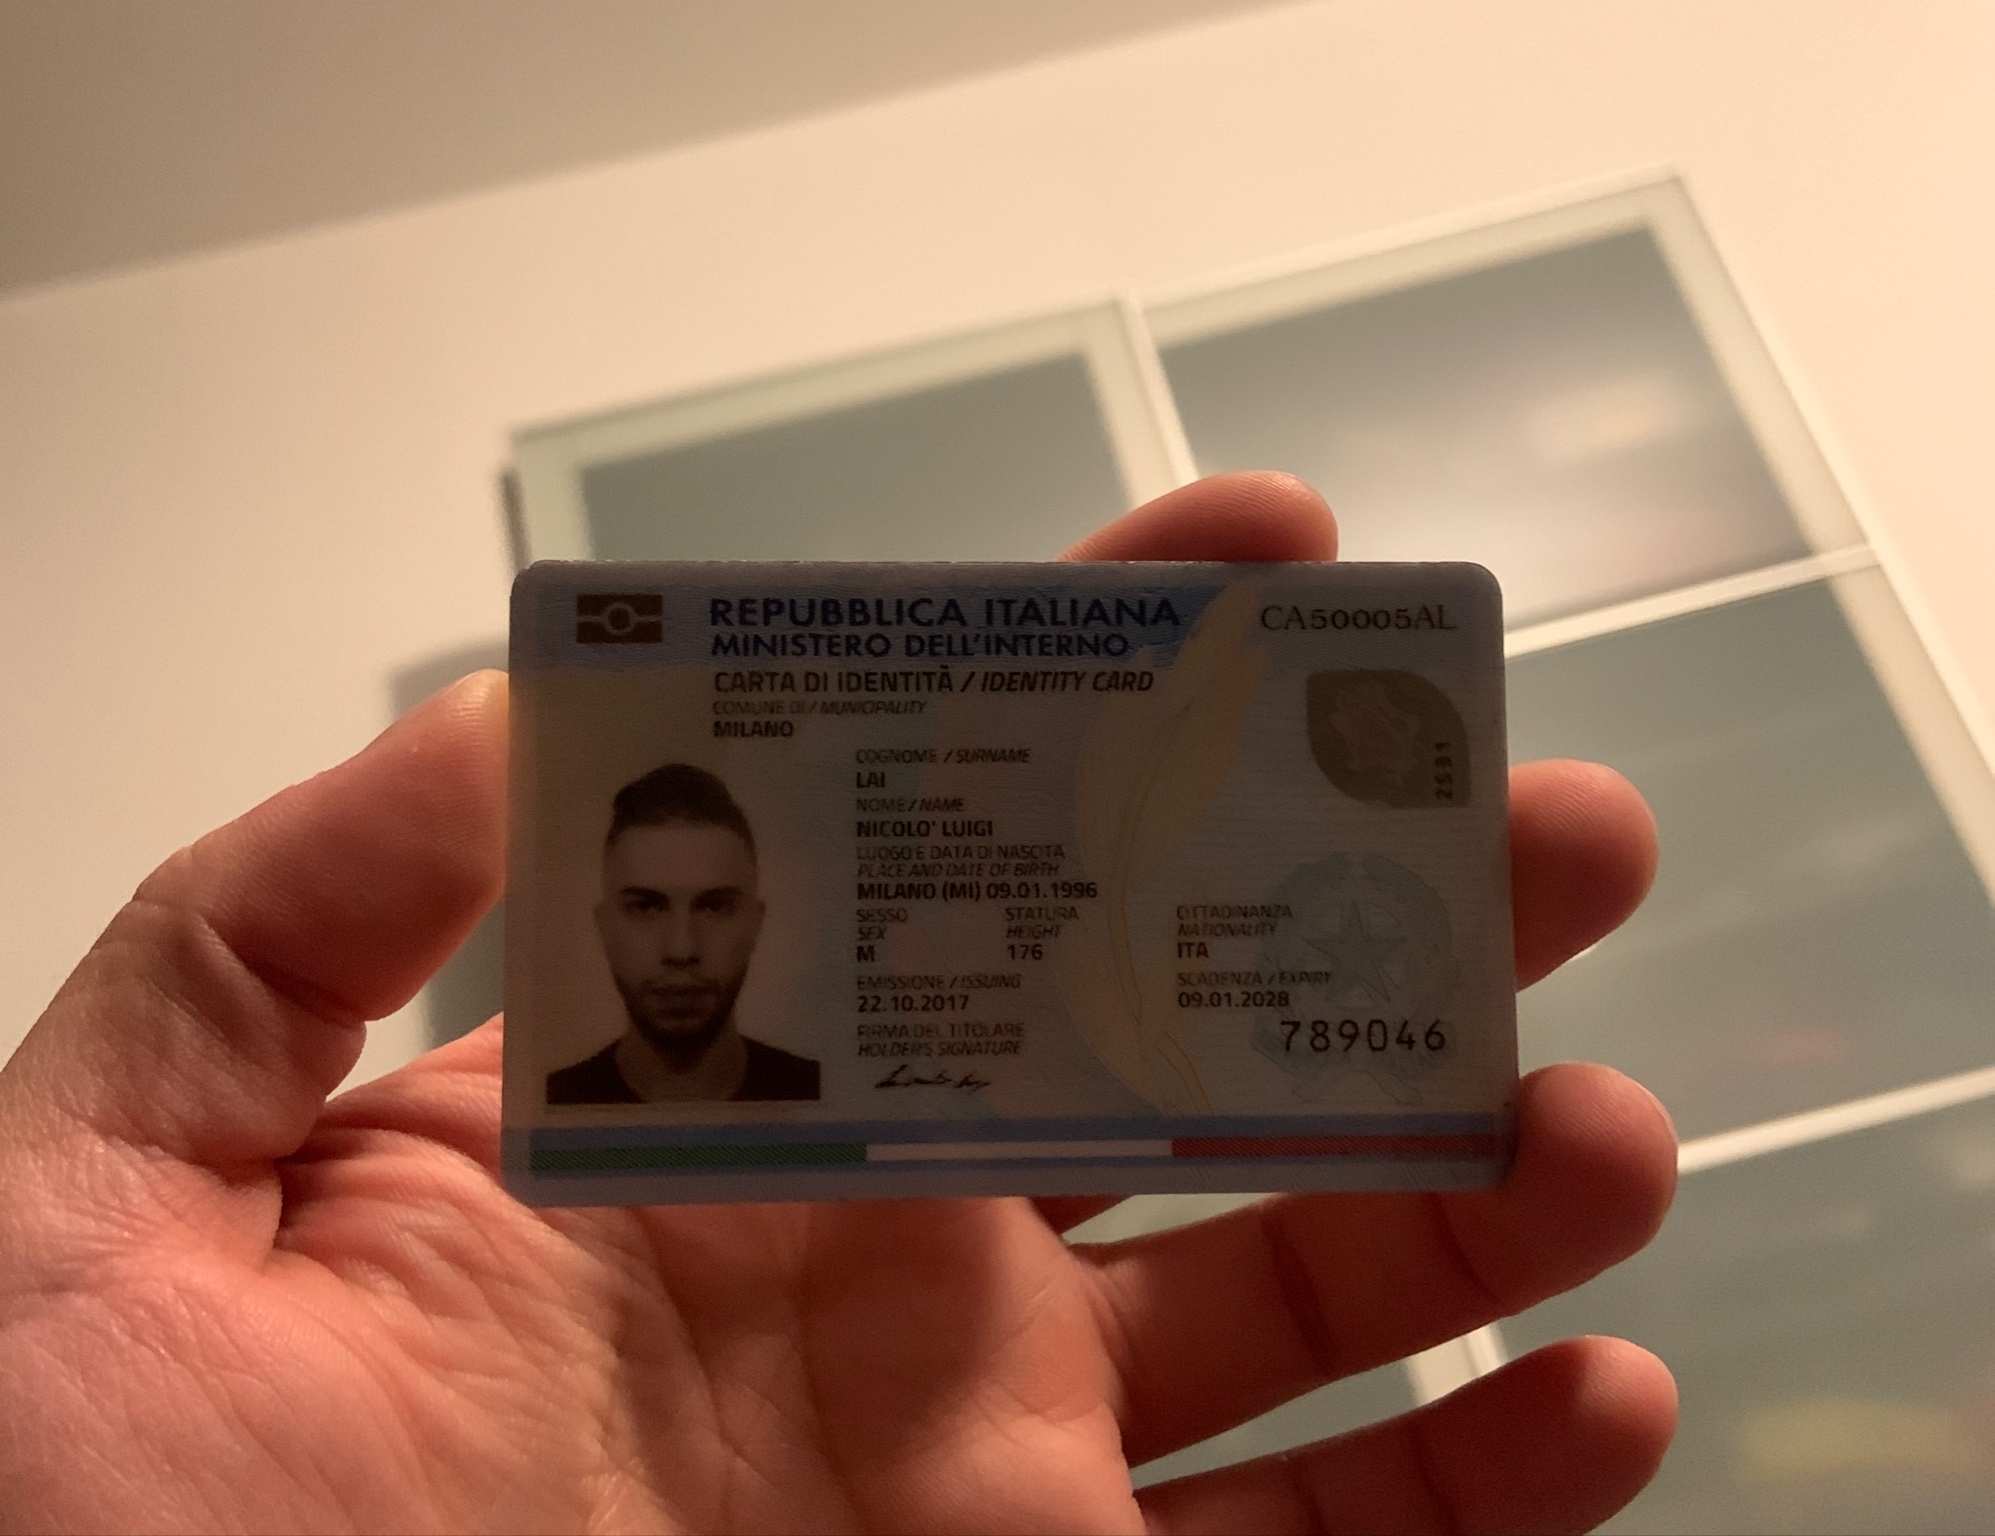

In [ ]:
# Load random image with wrong predictions

model_builder = model
last_conv_layer = model.layers[-19].name
print(last_conv_layer)

random_im = random.randint(0,len(array)-1)
image_path = X_test[array[random_im]]
print(image_path)
display(Image(image_path))

In [ ]:
# Vectorize the given image to get a numpy array

def vectorize_image(img_path, size):

    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    return array

[codecarbon INFO @ 09:15:45] Energy consumed for RAM : 0.007488 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:15:45] Energy consumed for all CPUs : 0.066952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:45] 0.074440 kWh of electricity used since the beginning.


In [ ]:
vectorized_image = preproc_mbt3(vectorize_image(image_path, size=inp_dim))

[[0.3951158  0.27133027 0.26508954 0.20921108 0.10966586 0.14232342
  0.2478339 ]
 [0.5894821  0.38879788 0.16816418 0.06070326 0.         0.04293193
  0.07668696]
 [0.34188822 0.20108218 0.05106129 0.35349163 0.44035125 0.22473994
  0.27396995]
 [0.18674324 1.         0.7427527  0.06414597 0.15855968 0.982794
  0.44710693]
 [0.         0.37677655 0.8182062  0.         0.         0.45230305
  0.44066694]
 [0.02911927 0.         0.         0.29638588 0.11226685 0.6849065
  0.2975479 ]
 [0.         0.         0.2984632  0.55086136 0.2251597  0.4861351
  0.6281353 ]]


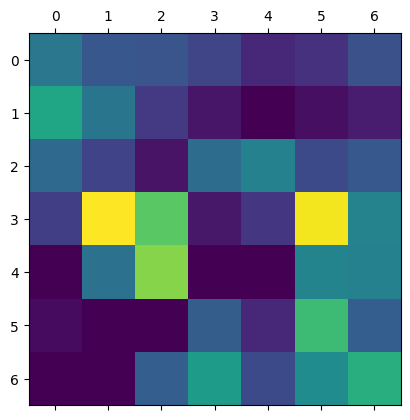

In [ ]:
# Function to visualize grad-cam heatmaps

def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):

    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

<ipython-input-102-66511ed51ba8>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = c_map.get_cmap("jet") # Colorizing heatmap


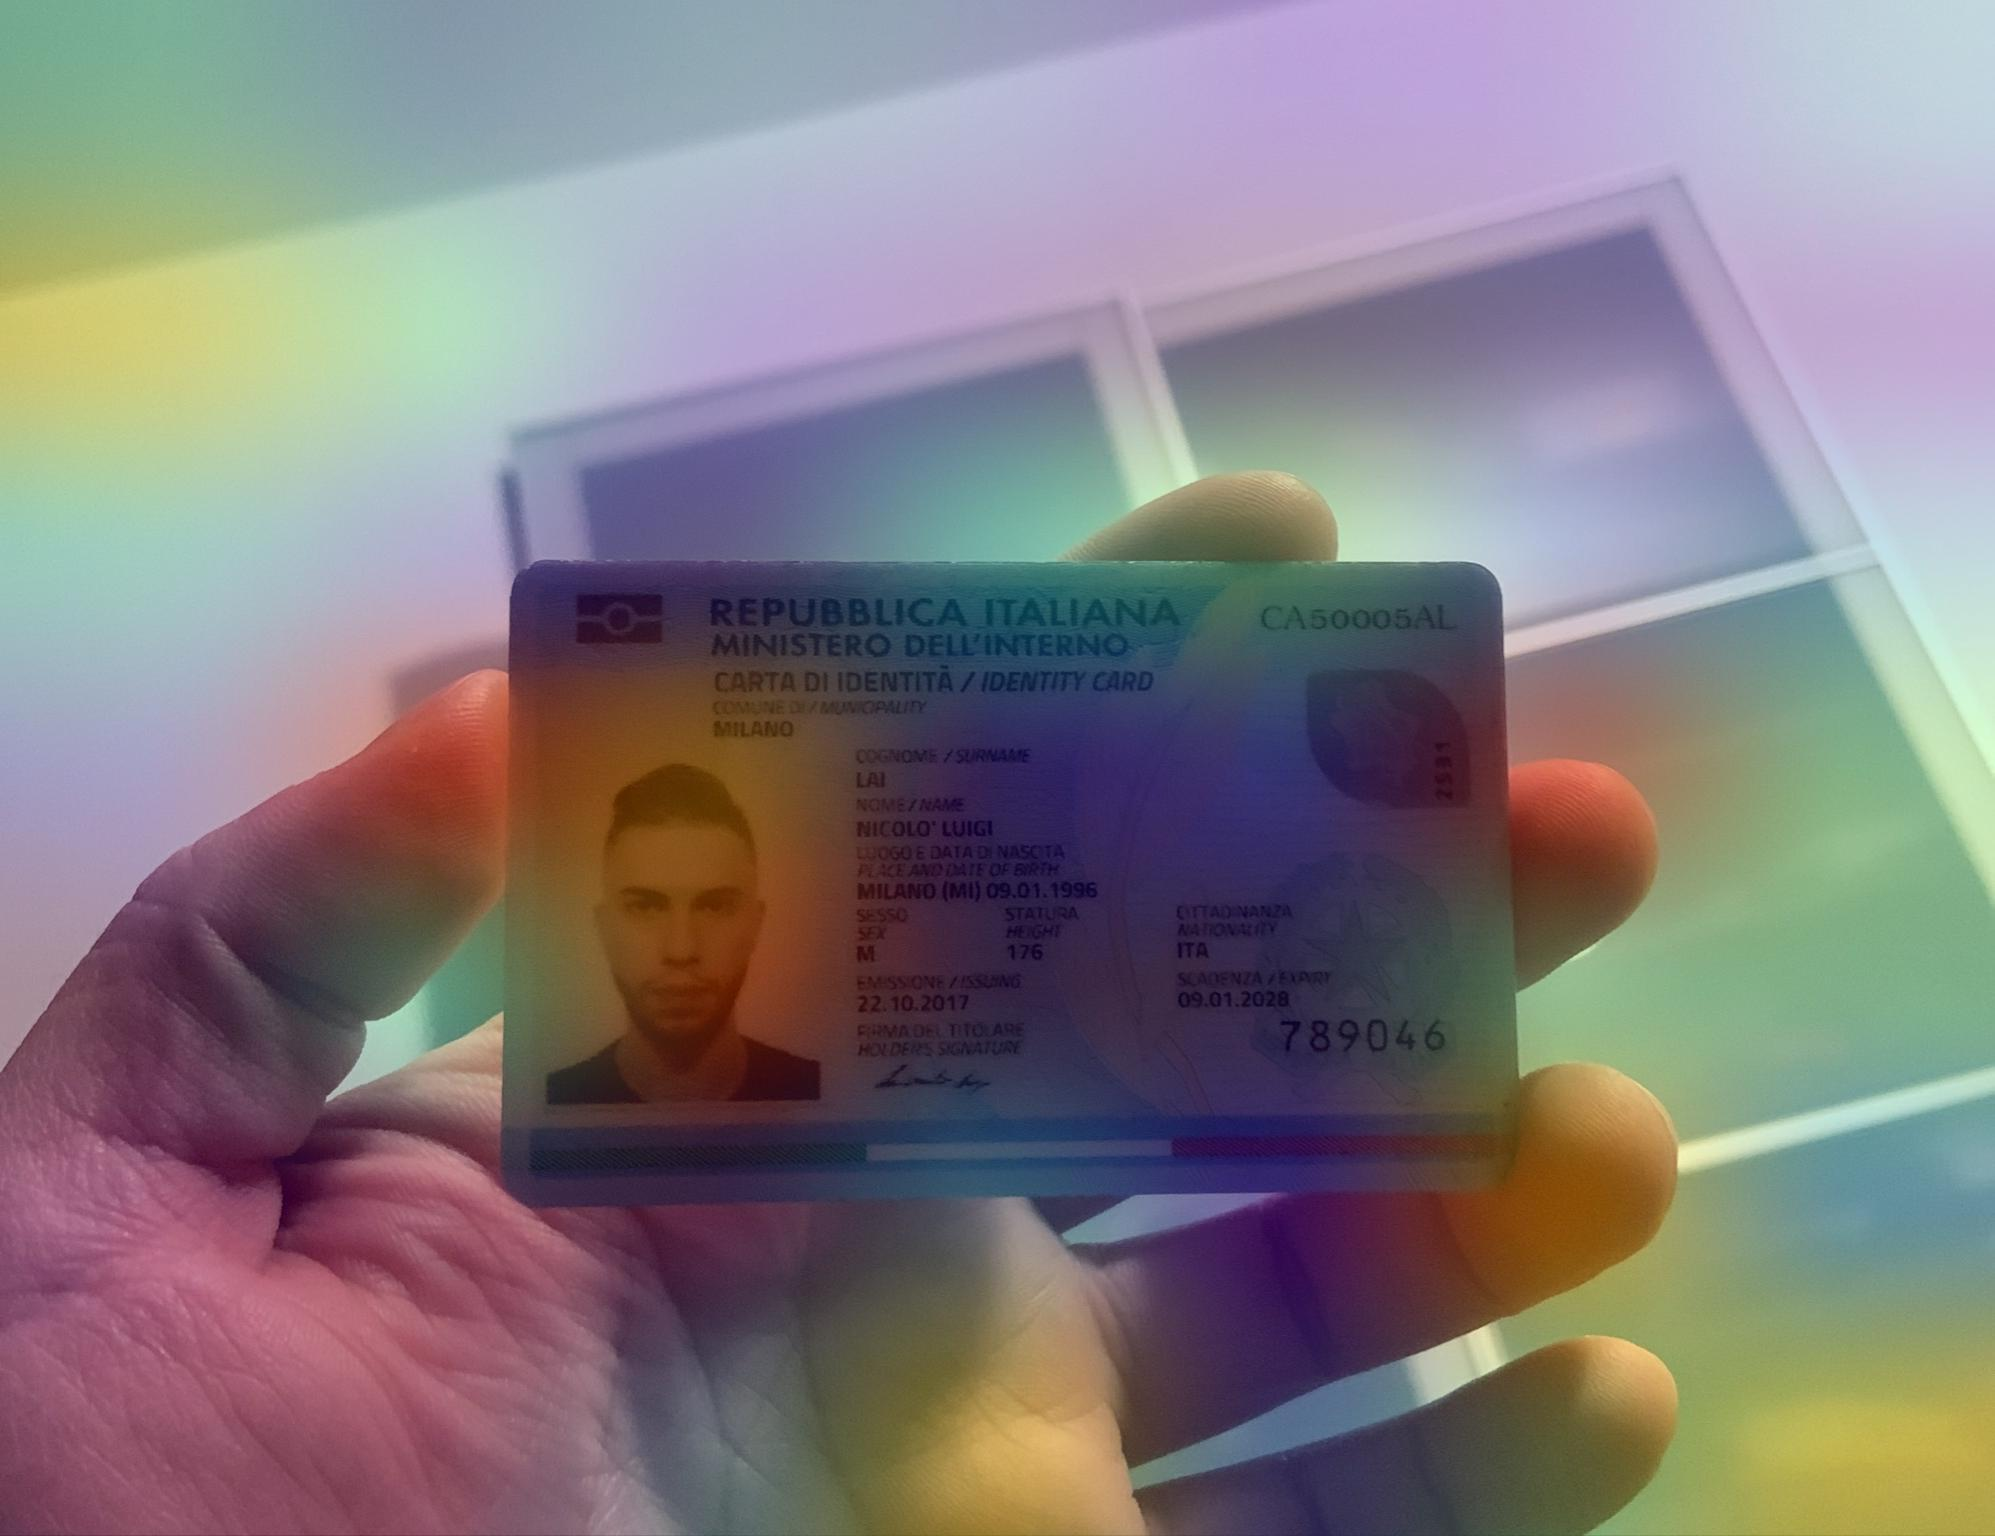

In [ ]:
# Superimpose Grad-CAM Heatmap on image

def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):

    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)


    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image

superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))